In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
import copy

In [2]:
DATASET_TYPES = ["AAVE_UK", "RAVDESS", "Accents"]

DATASET_TYPE_VAL = 0

DATASET_TYPE = DATASET_TYPES[DATASET_TYPE_VAL]

ASR_TYPES = ["MS_IBM", "GCP_IBM", "MS_GCP"]

TRANSFORMATION_TYPES = ["Amp", "Clipping", "Drop", "Frame", "HP", "LP", "Noise", "Scale"]

GROUPS = ['Male', 'Female']

# SAVE_FOLDER = "/Users/sakshiudeshi/Documents/SUTD/Research/LaTeX/speechPaper/figs/"
SAVE_FOLDER = "Saved_Imgs"

In [3]:
def get_groups(dataset_type = DATASET_TYPE):
    if dataset_type == DATASET_TYPES[0]:
        return ['AAVE', 'Midlands']
    
    elif dataset_type == DATASET_TYPES[1]:
        return ['Male', 'Female']
    
    else:
        return ['English', 'Ganda', 'French', 'Gujarati', 'Indonesian' ,'Korean', 'Russian']
    
GROUPS = get_groups()
print(GROUPS)

['English', 'Ganda', 'French', 'Gujarati', 'Indonesian', 'Korean', 'Russian']


In [4]:
def get_filename_filler(dataset_type = DATASET_TYPE):
    if dataset_type == "Accents":
        return " Differential Speech Results - "
    else: 
        return " - " 

In [5]:
def get_file_data(asr_type, transformation_type):
    file_name = DATASET_TYPE + "/" + asr_type + "/" + asr_type + \
    get_filename_filler() + transformation_type + ".csv"
    with open(file_name, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        file_arr = list(reader)
    return file_arr, transformation_type, asr_type

In [6]:
def get_diff_rows_range(transformation_type = TRANSFORMATION_TYPES[0]):
    if (transformation_type == "Amp"):
        return list(range(12, 18))
    elif (transformation_type == "Scale"):
        return list(range(11, 14))
    else:
        return list(range(11, 16))

In [7]:
# def get_orig_wer_rows_range(transformation_type = TRANSFORMATION_TYPES[0]):
#     if (transformation_type == "Amp"):
#         return [9]
#     else:
#         return [8]

In [8]:
def process_num_arr(num_arr):
    tag = str(num_arr[0])
    num_arr = num_arr[1:len(num_arr)]
    return [float(i) for i in num_arr], tag

In [9]:
def get_relevant_rows(file_data, transformation_type = TRANSFORMATION_TYPES[0]):
    diff_rows = get_diff_rows_range(transformation_type)
    row_arr, tag_arr = [], []
    for i in diff_rows:
        row, tag = process_num_arr(file_data[i - 1])
        row_arr.append(row)
        tag_arr.append(tag)
    return row_arr, tag_arr

In [10]:
# def get_original_wer(asr_type, transformation_type = TRANSFORMATION_TYPES[0]):
#     file_data, _, _ = get_file_data(asr_type, transformation_type)
#     diff_rows = get_orig_wer_rows_range(transformation_type)
#     row_arr, tag_arr = [], []
# #     print(file_data)
#     for i in diff_rows:
#         row, tag = process_num_arr(file_data[i - 1])
#         row_arr.append(row)
#         tag_arr.append(tag)
#     return row_arr, tag_arr

In [11]:
def get_formatted_diff_data(asr_type, transformation_type):
    file, _ , _  = get_file_data(asr_type = asr_type, transformation_type = transformation_type)
    row_arr, tag_arr = get_relevant_rows(file_data = file, transformation_type = trans_type)
#     for i, row in enumerate(row_arr):
#         print(tag_arr[i], row)
#     print()
    return row_arr, tag_arr

In [12]:
def get_error_data(asr_type, transformation_type, threshold = 0.1, languages = GROUPS):
    row_arr, tag_arr = get_formatted_diff_data(asr_type, transformation_type)
    
    row_error_arr = []
    
    for row in row_arr:
        error_arr = []
        for base_gr in range(len(row)):
            errors = 0
            for comp_gr in range(len(row)):
#                 print(base_gr , comp_gr)
                if(row[base_gr] - row[comp_gr] > threshold):
                     errors += 1
            error_arr.append(errors)
        row_error_arr.append(error_arr)
            
    return row_error_arr, tag_arr
            
            
        

In [13]:
def get_error_sums(row_error_arr):
    error_sum_arr = []
    for j in range(len(row_error_arr[0])):
        error_sum = 0
        for i in range(len(row_error_arr)):
            error_sum += row_error_arr[i][j]
        error_sum_arr.append(error_sum)
    return error_sum_arr

In [14]:
class error_data_nugget:
    def __init__(self, tau, asr_type, transformation_type, error_row):
        self.tau = tau
        self.asr_type = asr_type
        self.transformation_type = transformation_type
        self.error_row = error_row

In [15]:
def get_sum_error_data_nuggets():
    error_data_nuggets = []
    for tau in [0.01, 0.05, 0.1, 0.15]:
#         print(['Tau ' + str(tau)] )
        for asr_type in ASR_TYPES:
            sum_rows = []
            for trans_type in TRANSFORMATION_TYPES:
                row_error_arr, tag_arr = get_error_data(asr_type, trans_type, threshold=tau)

                sum_rows.append(get_error_sums(row_error_arr))

    #         for i, row_error in enumerate(sum_rows):
    #             print([''] + row_error)  
    #         print("-----------")
            error_sum_row = get_error_sums(sum_rows)
            error_data_nuggets.append(error_data_nugget(tau, asr_type, 'ALL', error_sum_row)) 
            
    return error_data_nuggets

In [16]:
def get_data_nugget_sums(error_data_nuggets):
    row_error_arr = []
    for nugget in error_data_nuggets:
        row_error_arr.append(nugget.error_row)
    return get_error_sums(row_error_arr)

In [17]:
error_data_nuggets = []
for tau in [0.01, 0.05, 0.1, 0.15]:
#     print(['Tau ' + str(tau)] )
    for asr_type in ASR_TYPES:
        sum_rows = []
        for trans_type in TRANSFORMATION_TYPES:
            row_error_arr, tag_arr = get_error_data(asr_type, trans_type, threshold=tau)
            error_data_nuggets.append(error_data_nugget(tau, asr_type, trans_type, get_error_sums(row_error_arr)))  

#             sum_rows.append(get_error_sums(row_error_arr))
            
#         for i, row_error in enumerate(sum_rows):
#             print([''] + row_error)  
#         print("-----------")
#         error_sum_row = get_error_sums(sum_rows) 
        
# error_data_nuggets = get_sum_error_data_nuggets()

In [18]:
def get_tau_data_subset(error_data_nuggets, tau = 0.01):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        if data.tau == tau:
            error_data_nuggets_subsets.append(data)
    return error_data_nuggets_subsets

In [19]:
def get_asr_type_data_subset(error_data_nuggets, asr_type = "MS_IBM"):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        if data.asr_type == asr_type:
            error_data_nuggets_subsets.append(data)
    return error_data_nuggets_subsets

In [20]:
def get_asr_gr_type_subset(error_data_nuggets, gr_val = 0):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        error_data_nuggets_subsets.append(error_data_nugget(data.tau, data.asr_type, 'ALL', [data.error_sum_row[gr_val]]))
    return error_data_nuggets_subsets

In [21]:
def get_asr_tr_type_subset(error_data_nuggets, tr_type = "Noise"):
    error_data_nuggets_subsets = []
    
    for data in error_data_nuggets:
        if data.transformation_type == tr_type:
            error_data_nuggets_subsets.append(data)    
    return error_data_nuggets_subsets

In [22]:
def autolabel(rects, dataset_type = DATASET_TYPE):
    
    
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if dataset_type == DATASET_TYPES[0]:
            text_height = height + max(0.02*height, 0.5)
    
        elif dataset_type == DATASET_TYPES[1]:
            text_height = height + max(0.02*height, 0.5)

        else:
            text_height = height + max(0.02*height, 3)
            
        ax.text(rect.get_x() + rect.get_width()/2., text_height,
                '%d' % int(height),
                ha='center', va='bottom', rotation="vertical")

In [23]:
def get_percentages(sum_arrs, base_gr = 0):
    p_sum_arrs = []
    for sum_arr in sum_arrs:
        p_sum_arr = []
        for i, val in enumerate(sum_arr):
            if i != base_gr:
                p_sum_arr.append(( val - sum_arr[base_gr]) * 100/sum_arr[base_gr])
        p_sum_arrs.append(p_sum_arr)
        
    return p_sum_arrs

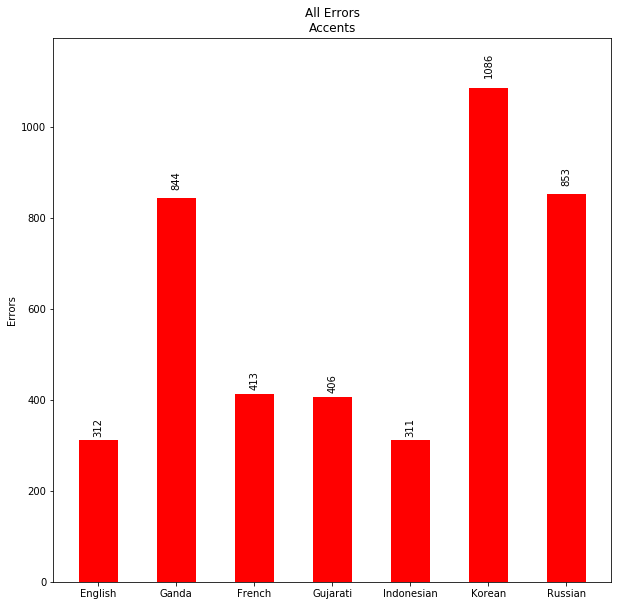

In [24]:
# All Errors plots
width = 0.5
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
error_data_nuggets_subset = copy.deepcopy(error_data_nuggets)
sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
sum_arrs.append(sum_arr)

# print(sum_arrs)
    
rects.append(ax.bar(ind + width, sum_arr, width = width, color=colors[0]))
#     plt.bar(LANGUAGES, sum_arr)


for rect in rects:
    autolabel(rect)
    
plt.ylim(top = np.max(sum_arrs) * 1.1)



# ax.legend((rect for rect in rects), (tau_val for tau_val in tau_vals))
ax.set_xticks(ind + width *1)
ax.set_xticklabels(GROUPS)
ax.set_ylabel('Errors')

plt.title ("All Errors\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-Total-Errors",bbox='tight', dpi=300)
plt.show()


115.35801778970385
[89.58333333333333, 143.77777777777777, 132.55813953488374, 95.51282051282051]
353.3333333333333
[126.78571428571429, 58.92857142857143, 38.095238095238095, 5.9523809523809526, 197.02380952380952, 110.71428571428571]
[226.66666666666666, 32.0, 34.666666666666664, 13.333333333333334, 353.3333333333333, 202.66666666666666]
[237.2093023255814, -9.30232558139535, 13.953488372093023, -20.930232558139537, 300.0, 274.4186046511628]
[180.76923076923077, -69.23076923076923, -7.6923076923076925, -46.15384615384615, 188.46153846153845, 326.9230769230769]


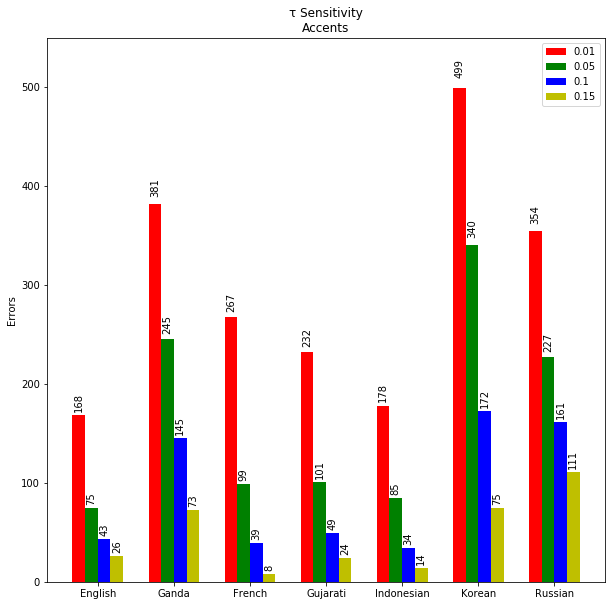

In [25]:
## Tau vary plots
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5
num_offset = 0.2


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
for i, tau_val in enumerate(tau_vals):
#     print(i)
    error_data_nuggets_subset = get_tau_data_subset(error_data_nuggets, tau = tau_val)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     ax.text(ind + width*i, sum_arr + num_offset , "5")
#     plt.bar(GROUPS, sum_arr)

print(np.mean (get_percentages(sum_arrs)))
print([np.mean(p_sum_arr) for p_sum_arr in get_percentages(sum_arrs)])
print(np.max(get_percentages(sum_arrs)))
for p_sum_arr in get_percentages(sum_arrs):
    print(p_sum_arr)

plt.ylim(top = np.max(sum_arrs) *1.1)


for rect in rects:
    autolabel(rect)


ax.legend((rect for rect in rects), (tau_val for tau_val in tau_vals))
ax.set_xticks(ind + width * 1.5)
ax.set_xticklabels( GROUPS)
ax.set_ylabel('Errors')
plt.title ("τ Sensitivity\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-Tau-Errors",bbox='tight', dpi=300)

plt.show()


215.49688189549556
[(537.9629629629629, 'MS_IBM'), (77.60814249363868, 'GCP_IBM'), (30.919540229885058, 'MS_GCP')]
977.7777777777778
[925.0, 255.55555555555554, 250.0, 77.77777777777777, 977.7777777777778, 741.6666666666666]
[148.0916030534351, -6.106870229007634, 12.213740458015268, -25.19083969465649, 161.06870229007635, 175.57251908396947]
[3.4482758620689653, 11.724137931034482, -8.275862068965518, 2.7586206896551726, 145.51724137931035, 30.344827586206897]


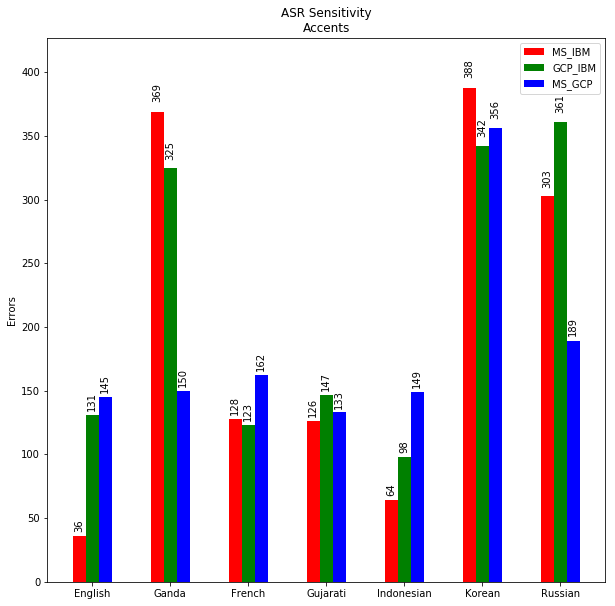

In [34]:
## ASR_TYPE vary plots
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
for i, asr_type in enumerate(ASR_TYPES):
    error_data_nuggets_subset = get_asr_type_data_subset(error_data_nuggets, asr_type = asr_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(GROUPS, sum_arr)

for rect in rects:
    autolabel(rect)
    
print(np.mean (get_percentages(sum_arrs)))
print([(np.mean(p_sum_arr[0]), p_sum_arr[1]) for p_sum_arr in zip(get_percentages(sum_arrs), ASR_TYPES)])
print(np.max(get_percentages(sum_arrs)))
for p_sum_arr in get_percentages(sum_arrs):
    print(p_sum_arr)
    
plt.ylim(top = np.max(sum_arrs) *1.1)



ax.legend((rect for rect in rects), (asr_type for asr_type in ASR_TYPES))
ax.set_xticks(ind + width * 1)
ax.set_xticklabels( GROUPS)
ax.set_ylabel('Errors')
plt.title ("ASR Sensitivity\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-ASRErrors",bbox='tight', dpi=300)

plt.show()


[0.5 2.  3.5 5.  6.5 8.  9.5]
1444.642857142857
[(3104.1666666666665, 'Clipping'), (825.0, 'Drop'), (404.7619047619048, 'Frame')]
5825.0
[1925.0, 850.0, 3875.0, 1700.0, 4450.0, 5825.0]
[1312.5, 312.5, 262.5, 400.0, 2200.0, 462.5]
[657.1428571428571, 335.7142857142857, 78.57142857142857, 157.14285714285714, 1114.2857142857142, 85.71428571428571]


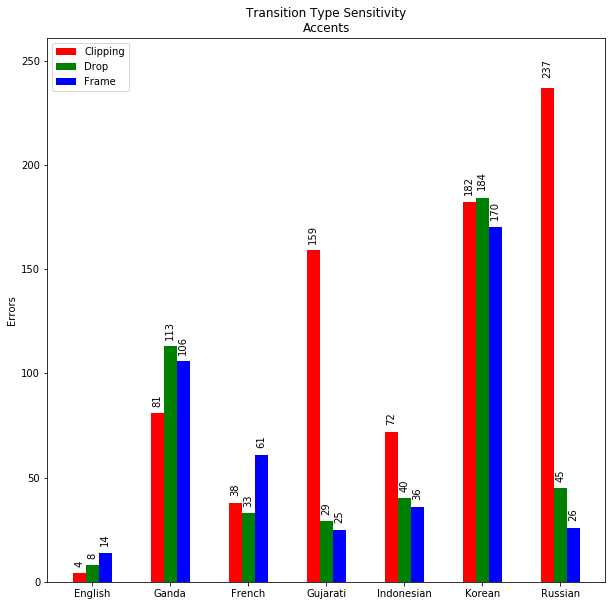

In [36]:
## Tr_Type vary plots where English does very well
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Clipping", "Drop", "Frame"]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

rects = []

sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)

for rect in rects:
    autolabel(rect)
    
plt.ylim(top = np.max(sum_arrs) *1.1)

print(np.mean (get_percentages(sum_arrs)))
print([(np.mean(p_sum_arr[0]), p_sum_arr[1]) for p_sum_arr in zip(get_percentages(sum_arrs), TR_TYPES)])
print(np.max(get_percentages(sum_arrs)))
for p_sum_arr in get_percentages(sum_arrs):
    print(p_sum_arr)
    



ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width )
ax.set_xticklabels(GROUPS)
ax.set_ylabel('Errors')
plt.title ("Transition Type Sensitivity\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-Transition-1-Errors",bbox='tight', dpi=300)

plt.show()


[0.4 1.9 3.4 4.9 6.4 7.9 9.4]
1239.957264957265
[(2300.0, 'Noise'), (179.9145299145299, 'LP')]
4240.0
[2460.0, 980.0, 1620.0, 340.0, 4240.0, 4160.0]
[305.12820512820514, 176.92307692307693, 46.15384615384615, -64.1025641025641, 182.05128205128204, 433.3333333333333]


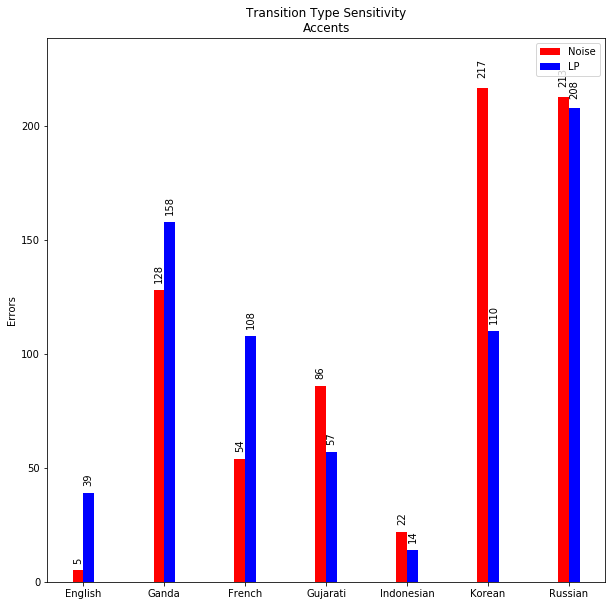

In [38]:
## Tr_Type vary plots where English does very well
width = 0.2
# spacing = 0.2
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Noise", "LP"]

if(DATASET_TYPE_VAL == 0):
    TR_TYPES = TR_TYPES + []
    multiplier = 0.5
elif(DATASET_TYPE_VAL == 1):
    TR_TYPES = TR_TYPES + ["Amp"]
    multiplier = 1   
else:
    multiplier = 0.5


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

rects = []

plt.ylim(top = np.max(sum_arrs) *1.1)


sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(GROUPS, sum_arr)

for rect in rects:
    autolabel(rect)
    

print(np.mean (get_percentages(sum_arrs)))
print([(np.mean(p_sum_arr[0]), p_sum_arr[1]) for p_sum_arr in zip(get_percentages(sum_arrs), TR_TYPES)])
print(np.max(get_percentages(sum_arrs)))
for p_sum_arr in get_percentages(sum_arrs):
    print(p_sum_arr)
    
    
plt.ylim(top = np.max(sum_arrs) *1.1)



ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width * multiplier )
ax.set_xticklabels(GROUPS)
ax.set_ylabel('Errors')
plt.title ("Transition Type Sensitivity\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-Transition-2-Errors",bbox='tight', dpi=300)

plt.show()


[0.25 1.75 3.25 4.75 6.25 7.75 9.25]
-30.7835904005702
[(-63.78600823045267, 'Amp'), (-39.91228070175438, 'HP'), (11.34751773049645, 'Scale')]
104.25531914893617
[-76.54320987654322, -45.67901234567901, -59.25925925925926, -82.71604938271605, -50.617283950617285, -67.90123456790124]
[47.36842105263158, -74.56140350877193, -92.10526315789474, -46.49122807017544, -23.68421052631579, -50.0]
[51.06382978723404, -2.127659574468085, -82.97872340425532, 10.638297872340425, 104.25531914893617, -12.76595744680851]


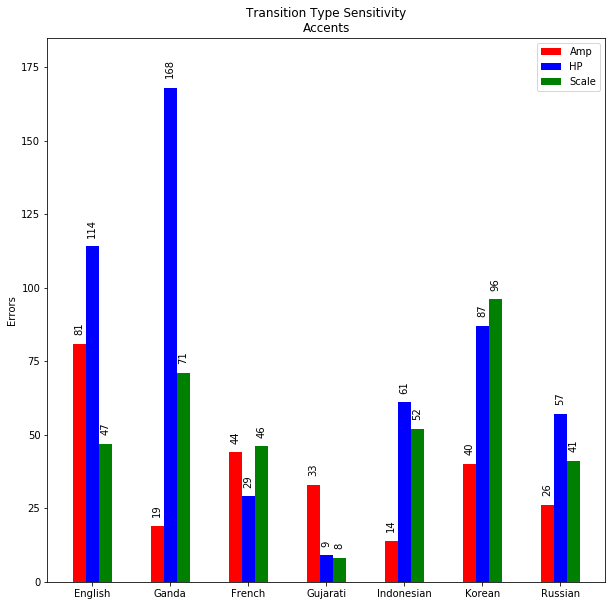

In [39]:
## Tr_Type vary plots where English does comparaby to others
width = 0.25
# spacing = 0.2
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Amp", "HP", "Scale"]


if(DATASET_TYPE_VAL == 0):
    TR_TYPES = TR_TYPES + []
    multiplier = 1
elif(DATASET_TYPE_VAL == 1):
    TR_TYPES = ["HP", "Scale"]
    multiplier = 0.5
else:
    multiplier = 1


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(GROUPS)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

plt.ylim(top = np.max(sum_arrs) *1.1)





rects = []

sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(GROUPS, sum_arr)

for rect in rects:
    autolabel(rect)
    
plt.ylim(top = np.max(sum_arrs) *1.1)

print(np.mean (get_percentages(sum_arrs)))
print([(np.mean(p_sum_arr[0]), p_sum_arr[1]) for p_sum_arr in zip(get_percentages(sum_arrs), TR_TYPES)])
print(np.max(get_percentages(sum_arrs)))
for p_sum_arr in get_percentages(sum_arrs):
    print(p_sum_arr)
    



ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width * multiplier)
ax.set_xticklabels(GROUPS)
ax.set_ylabel('Errors')
plt.title ("Transition Type Sensitivity\n" + DATASET_TYPE)
plt.savefig(SAVE_FOLDER + DATASET_TYPE + "-Transition-3-Errors",bbox='tight', dpi=300)

plt.show()


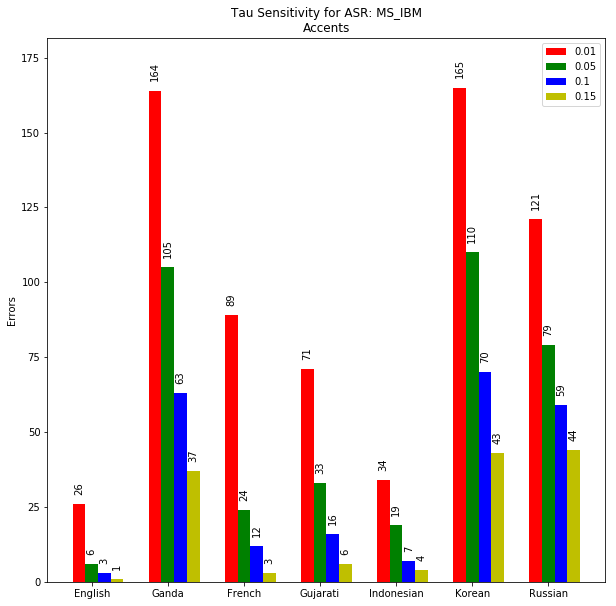

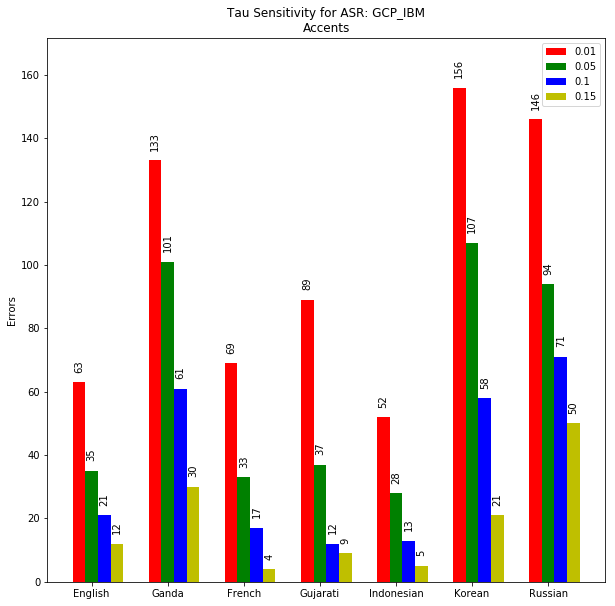

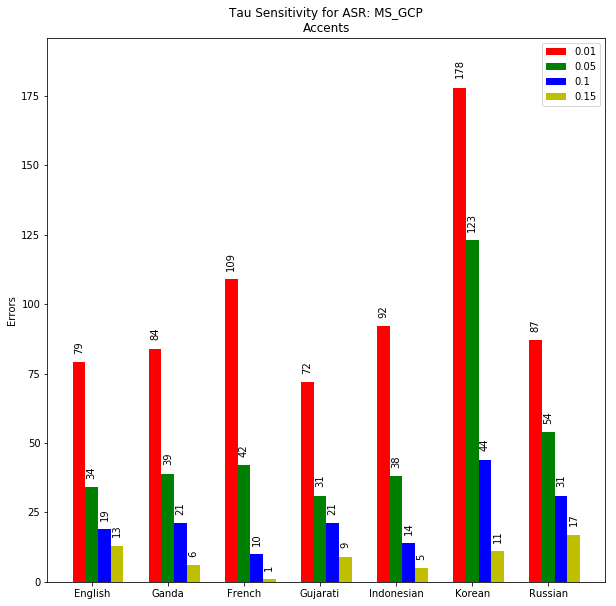

In [30]:

## ASR_TYPE vary plots

for i, asr_type in enumerate(ASR_TYPES):
    width = 0.25
    # spacing = 0.2
    colors = ['r', 'g', 'b', 'y']
    tau_vals = [0.01, 0.05, 0.1, 0.15]
    step_size = 1.5


    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    N = len(GROUPS)
    ind = np.arange(N * step_size, step = step_size) 
    # print(ind + width*i)

    rects = []

    sum_arrs = []
    #     error_data_nuggets_subset = get_asr_type_data_subset(error_data_nuggets, asr_type = asr_type)
    for i, tau_val in enumerate(tau_vals):
        error_data_nuggets_subset = get_asr_type_data_subset(get_tau_data_subset(error_data_nuggets, tau = tau_val), asr_type = asr_type)
        sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
        sum_arrs.append(sum_arr)
        rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))

    for rect in rects:
        autolabel(rect)

    plt.ylim(top = np.max(sum_arrs) *1.1)



    ax.legend((rect for rect in rects), (tau_vals for tau_vals in tau_vals))
    ax.set_xticks(ind + width * 1)
    ax.set_xticklabels( GROUPS)
    ax.set_ylabel('Errors')
    plt.title ("Tau Sensitivity for ASR: "+ asr_type +"\n" + DATASET_TYPE)
    # plt.savefig(SAVE_FOLDER + DATASET_TYPE + " - ASR Errors",bbox='tight', dpi=300)

    plt.show()


## 